In [42]:
from src.tools import MMseqs, NCBIDatasets, UniRef
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile, GBFFFile
from utils import * 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from src.classifier import Classifier
from src.sampler import Sampler
from src.dataset import Dataset
import re 

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def get_inference_proteins(genome_id:str, pseudo:bool=True):
    '''Extract the protein IDs for the non-redundant sequences.'''
    path = f'../data/proteins/inference/{genome_id}_protein.faa'
    if os.path.exists(path):
        return 
        
    df = GBFFFile(f'../data/proteins/ncbi/{genome_id}_genomic.gbff').to_df()
    df = df[df.evidence_type == 'similar to AA sequence']
    df = df[df.pseudo] if pseudo else df

    tools = {'RefSeq':NCBIDatasets(), 'UniRef':UniRef()}
    protein_ids = {'RefSeq':[], 'UniRef':[]}

    for row in df.itertuples():
        protein_id = row.evidence_details
        protein_ids[row.evidence_source].append(protein_id)

    inference_df = []
    for source, protein_ids in protein_ids.items():
        tool = tools[source]
        if len(protein_ids) > 0:
            df_ = tool.run(protein_ids=np.unique(protein_ids), path=None)
            tool.cleanup()
            inference_df.append(df_)

    if len(inference_df) == 0:
        print(f'get_inference_proteins: No inference proteins found for genome {genome_id}.')
        return 
        
    inference_df = pd.concat(inference_df)
    FASTAFile(df=inference_df).write(path)
    return inference_df

for genome_id in genome_ids['low_gc_content']:
    get_inference_proteins(genome_id)

In [60]:
ncbi_genome_metadata_df = load_ncbi_genome_metadata()

for level in ['phylum', 'class', 'order', 'genus']:
    print(f'{level.capitalize()} count:', ncbi_genome_metadata_df[f'{level}'].nunique())
    # print(f'Species with no {level}:', (genome_metadata_df[f'{level}_taxid'] == 'none').sum())

# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(15, 5), width_ratios=[0.3, 0.7])

# counts, bins, _ = ax_a.hist(ncbi_genome_metadata_df.gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
# ax_a.set_ylabel('density')
# ax_a.set_xlabel('GC percent')

# level = 'phylum'
# # x = np.arange(genome_metadata_df[f'{level}_taxid'].nunique())
# y = ncbi_genome_metadata_df.groupby(level).gc_percent.mean() # .sort_values(ascending=True)
# x = ncbi_genome_metadata_df.groupby(level).apply(len, include_groups=False) # .sort_values(ascending=True)
# y_err = ncbi_genome_metadata_df.groupby(level).apply(lambda df : df.gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]

# ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
# ax_b.scatter(x, y, color='black', s=5)
# ax_b.set_xscale('log')
# ax_b.set_xlabel(f'log({level} size)')
# ax_b.set_ylabel('GC percent')

plt.show()

Phylum count: 56
Class count: 123
Order count: 299
Genus count: 3983


In [74]:
# How should I select the genomes for model training?

# Using the same genomes for validation as in the Prodigal paper
# Halobacterium salinarum
# Natronomonas pharaonis
# Aeropyrum pernix
model_organism_genome_ids = ['GCF_000005845.2'] # E. coli K-12
model_organism_genome_ids += ['GCF_000009045.1'] # B. subtilis
model_organism_genome_ids += ['GCF_000006765.1'] # P. aeruginosa

# Start by selecting a few phyla in a reasonable size range with varying GC contents.
def sample(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

    phylum_sizes = genome_metadata_df.groupby('phylum').apply(len, include_groups=False)
    phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

    genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum.isin(phylum_sizes.index)]
    
    phylum_gc_percent = genome_metadata_df.groupby('phylum').gc_percent.mean() 
    phylum_gc_percent = phylum_gc_percent.sort_values(ascending=True)
    
    phyla = dict()
    phyla['low_gc_content'] = phylum_gc_percent.index[0]
    phyla['med_gc_content'] = phylum_gc_percent.index[len(phylum_gc_percent) // 2]
    phyla['high_gc_content'] = phylum_gc_percent.index[-1]

    print('Low-GC content phylum:', phyla['low_gc_content'])
    print('Medium-GC content phylum:', phyla['med_gc_content'])
    print('High-GC content phylum:', phyla['high_gc_content'])

    genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum == phylum] for category, phylum in phyla.items()}
    return genome_ids

genome_ids = sample(ncbi_genome_metadata_df)

# ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
# ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

Low-GC content phylum: Campylobacterota
Medium-GC content phylum: Planctomycetota
High-GC content phylum: Deinococcota


In [65]:
genome_metadata_df = list()
for category, genome_ids_ in genome_ids.items():
    df = ncbi_genome_metadata_df.loc[genome_ids_, :].copy()
    df['gc_percent_category'] = category
    # df = df[genome_metadata_df.annotation_pipeline.str.contains('PGAP')] # Only include genomes annotated with PGAP, because the other files are not consistent. 
    genome_metadata_df.append(df)
genome_metadata_df = pd.concat(genome_metadata_df)
genome_metadata_df.to_csv('../data/genome_metadata.csv')

In [ ]:
# ! ref --input-path ../data/proteins/prodigal/* --output-dir ../data/ref --reference-dir ../data/proteins/ncbi/ --prodigal-output --summarize

In [87]:
ref_df = load_ref(genome_ids=genome_metadata_df.index)

In [93]:
ref_df[ref_df.spurious & ref_df.top_hit_pseudo][['query_overlap_fraction', 'top_hit_overlap_fraction', 'in_frame', 'query_start', 'query_stop', 'top_hit_start', 'top_hit_stop']]
ref_df[ref_df.spurious].top_hit_feature.value_counts()

top_hit_feature
CDS              571
rRNA             321
repeat_region     58
tRNA              56
misc_feature      41
ncRNA              4
tmRNA              3
regulatory         3
Name: count, dtype: int64

In [ ]:
def check_spurious():
    

In [ ]:
# Now need to think about how I am going to create the datasets. Definitely will want to start with one per phylum, 
# and for starters, only include things I have definite labels for in the training. 

# Do I want to remove partial sequences? I think maybe not, because there are some sequences labeled partial by Prodigal
# that are not partial in the reference due to incorrect gene boundaries. I'll just keep them all in. 

def build_datasets(genome_metadata_df:pd.DataFrame, phylum:str='Campylobacterota', max_length:int=2000):
    # First remove things which do not have definitive labels. 
    genome_ids = genome_metadata_df[genome_metadata_df.phylum == phylum].index
    print(f'build_datasets: Loading data from {len(genome_ids)} genomes belonging to the phylum {phylum}.')
    df = load_ref(genome_ids=genome_ids)
    print(f'build_datasets: Loaded {len(ref_df)} sequences.')

    df = df[df.spurious | df.real].copy()
    print(f'build_datasets: Kept {df.spurious.sum()} spurious sequences and {df.real.sum()} real sequences.')
    df['label'] = df.real.astype(int)

    lengths = get_lengths(df, top_hit=False)
    print(f'Removing {(lengths >= max_length).sum()} sequences exceeding the maximum length of {max_length}')
    df = df[lengths < max_length]

    mmseqs = MMseqs()
    re = mmseqs.cluster(df, job_name=f'{phylum.lower()}_95', sequence_identity=0.95, reps_only=True, overwrite=True)
    mmseqs.cleanup()

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idxs, test_idxs = list(gss.split(df, groups=df.genome_id))[0]
    train_df, test_df = df.iloc[train_idxs], df.iloc[test_idxs]
    print(f'build_datasets: Training dataset contains {len(train_df)} sequences, testing dataset contains {len(test_df)} sequences.')
    print(f'build_datasets: {(train_df.label == 0).sum()} negative instances and {(train_df.label == 1).sum()} positive instances in the training dataset.')
    print(f'build_datasets: {(test_df.label == 0).sum()} negative instances and {(test_df.label == 1).sum()} positive instances in the testing dataset.')
    train_df.to_csv(f'../data/{phylum.lower()}_dataset_train.csv')
    test_df.to_csv(f'../data/{phylum.lower()}_dataset_test.csv')
    return train_df, test_df 
    
train_df, test_df = build_datasets(genome_metadata_df)
    



build_datasets: Loading data from 197 genomes belonging to the phylum Campylobacterota.
build_datasets: Loaded 1640383 sequences.
build_datasets: Kept 4147 spurious sequences and 360557 real sequences.
Removing 346 sequences exceeding the maximum length of 2000
MMseqs.load: Removing 44701 non-cluster representatives.
build_datasets: Training dataset contains 287552 sequences, testing dataset contains 76806 sequences.
build_datasets: 3190 negative instances and 284362 positive instances in the training dataset.
build_datasets: 949 negative instances and 75857 positive instances in the testing dataset.


In [ ]:
# There still seems to be something wrong with the training data, perhaps I am still misclassifying the spurious sequences?
# It is possible my "in-frame" check is wrong, it's possible I should only see if either edge is a multiple of 3 base pairs away, 
# as opposed to both.

# It seems as though 684 of the sequences flagged as spurious have an overlap length of 0, so maybe I should be counting those as intergenic?
# Ok, so I think because of how frequent gene overlap is, I should be allowing some (considering genes with less than a certain amount of overlap to be intergenic)
# I should also be very conservative, i.e. allow a comparatively large amount of overlap. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/ 


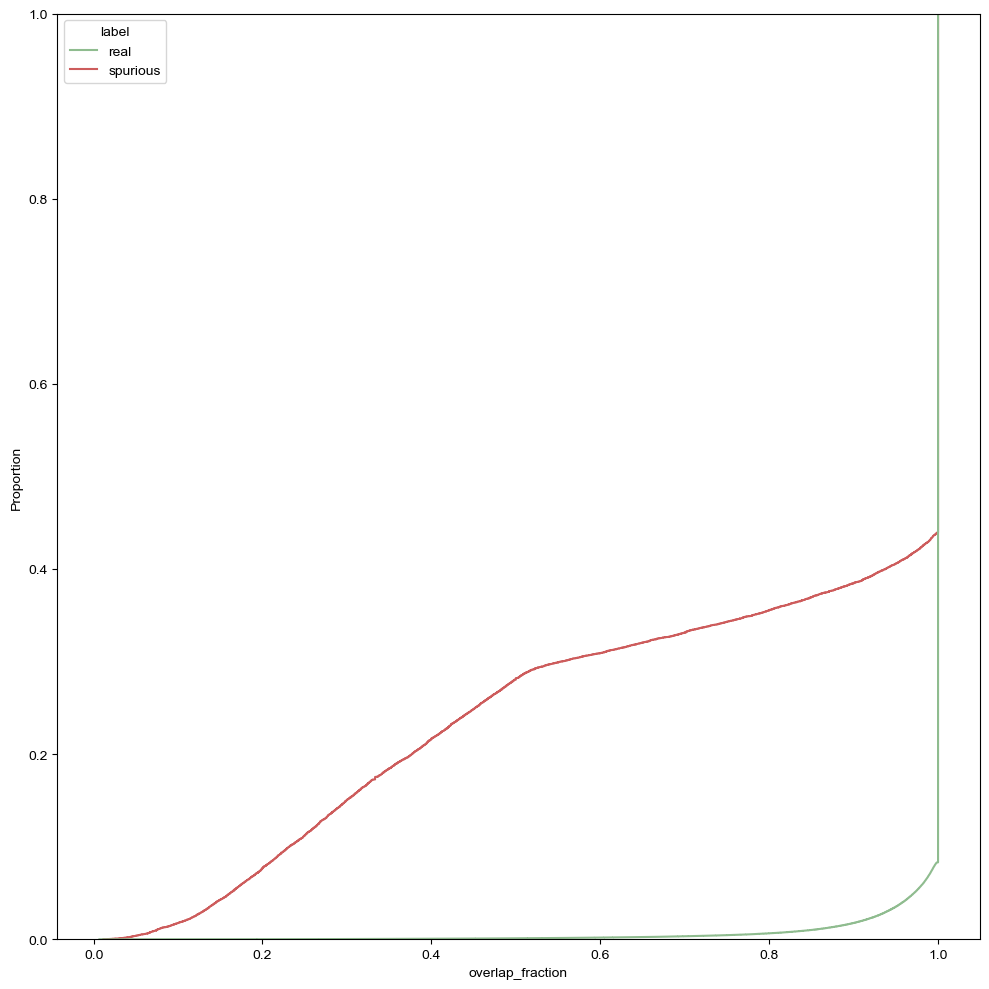

In [ ]:
# Curious about the distribution of overlap sizes... 


def figure(ref_df:pd.DataFrame, path:str=None, min_overlap_fraction:float=0.8):
    # ref_df = load_ref(genome_ids=genome_ids)
    ref_df = ref_df[ref_df.spurious | ref_df.real].copy()

    fig = plt.figure(figsize=(10, 10), layout='tight')
    grid = GridSpec(nrows=1, ncols=1, figure=fig)
    ax_a = fig.add_subplot(grid[0, 0])

    ax_a_df = pd.DataFrame(index=ref_df.index)
    ax_a_df['length'] = get_lengths(ref_df, top_hit=False, units='nt')
    ax_a_df['overlap_length'] = ref_df['top_hit_overlap_length']
    ax_a_df['overlap_fraction'] = ax_a_df.overlap_length / ax_a_df.length # This is relative to the query sequence. 
    ax_a_df['label'] = np.select([ref_df.real, ref_df.spurious], ['real', 'spurious'], default='none')
    if min_overlap_fraction is not None:
        ax_a_df = ax_a_df[ax_a_df.overlap_fraction > min_overlap_fraction].copy()

    colors = ['darkseagreen', 'indianred']
    # sns.kdeplot(data=ax_a_df, ax=ax_a, hue='label', hue_order=['real', 'spurious'], palette=colors, common_norm=False, x='overlap_fraction')
    sns.ecdfplot(data=ax_a_df, ax=ax_a, hue='label', hue_order=['real', 'spurious'], palette=colors, x='overlap_fraction')

    plt.show()
    return ax_a_df


ax_a_df = figure(ref_df, min_overlap_fraction=None)